In [1]:
import numpy as np
import pandas as pd

import cv2
import requests
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import os
import glob

Define the repeated image that doesn't give any information

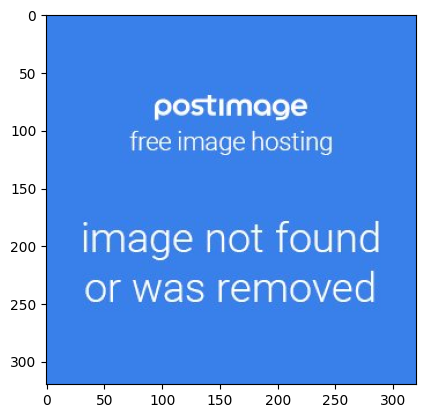

In [2]:
file = 'img_train_plaintext.txt'
df = pd.read_csv(file, delimiter="\t")
image_url = df.iloc[0, 1]
response = requests.get(image_url)
unwanted_img = Image.open(BytesIO(response.content))
plt.imshow(unwanted_img)

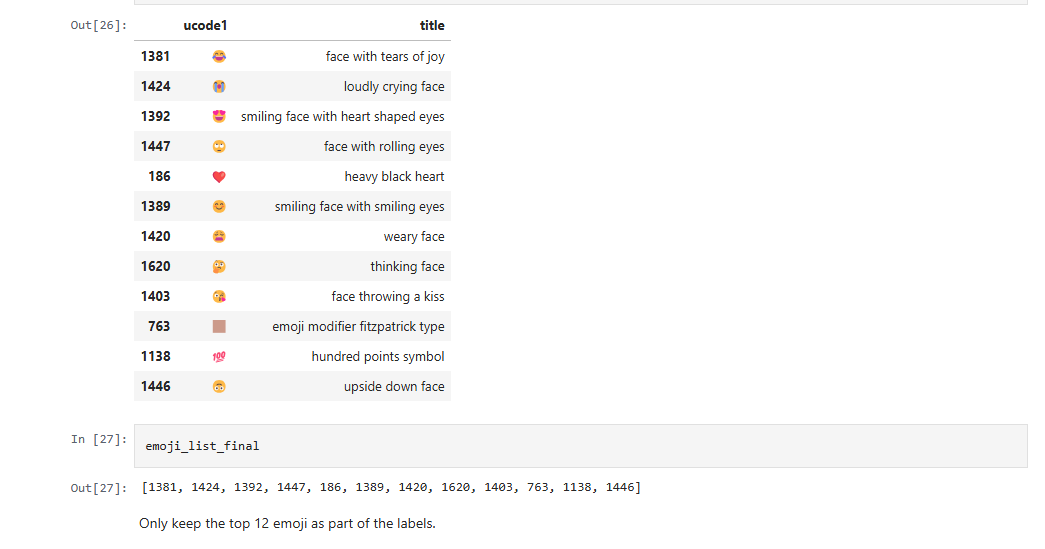

We filter out the top12 emojis but we will remove the emoji modifier, hence we are left with the top11.
We also check that the requests for image are valid.

In [3]:
top11 = [1381, 1424, 1392, 1447, 186, 1389, 1420, 1620, 1403, 1138, 1446]

def embed_label(label):
    res = []
    for i in top11:
        if i in label:
            res.append(1)
        else:
            res.append(0)
    return(res)

def find_top11(row): 
    res = []
    for ele in row: # ele is a str
        # extract out emojis in the top11 
        if ele in top11:
            if ele not in res:
                res.append(ele)
    return(res)    

def keep_top11(row):
    if len(row) > 0:
        return True
    else:
        return False
    
def check_img(image_url):
    try:
        # Send a GET request to fetch the image
        response = requests.get(image_url)
            
        # Raise an exception for a bad HTTP response
        response.raise_for_status()
        
        # Open the image from the content using PIL
        img = Image.open(BytesIO(response.content))
        if img == unwanted_img:
            return False
        else:
            return True  
          
    except requests.exceptions.RequestException as e:
        return False
        
    except IOError as e:
        return False
    

check_img may give different amount of rows/observations during the filtering because of real time use of requests.get

However, given that there are still ~12,000 rows in valid and test, and ~100,000 rows in train set, we deem it sufficient.

In [ ]:

for file in glob.glob("*.txt"):
    filename = os.path.splitext(file)[0]
    print(filename)
    # Read the tab-delimited file into a DataFrame
    df = pd.read_csv(file, delimiter="\t")
    print(df.shape) 
    df['annotations'] = list(map(int, row) for row in df['annotations'].str.split(','))
    df['annotations'] = df['annotations'].apply(find_top11)
    df = df[df['annotations'].apply(keep_top11)]
    print(df.shape) 
    df = df[df['imgid'].apply(check_img)]
    print(df.shape) 
    csvfile = filename + "_top11.csv"
    df.to_csv(csvfile, index=False)

In [4]:
IMG_SIZE = (224, 224)

for file in glob.glob("*.csv"):
    filename = os.path.splitext(file)[0]
    print(filename)
    # Read the csv file into a DataFrame
    df = pd.read_csv(file, delimiter=",", converters={'annotations': lambda x: list(map(int, x[1:-1].split(',')))})
    rgb = []
    edges = []
    labels = []
    print(df.shape)
    
    # DataFrame has 3 columns: id, imgid, annotations(labels)
    for i in range(0, df.shape[0]):
        image_url = df.iloc[i, 1]
        try:
            # Send a GET request to fetch the image
            response = requests.get(image_url)
            
            # Raise an exception for a bad HTTP response
            response.raise_for_status()

            # Open the image from the content using PIL
            img = Image.open(BytesIO(response.content))
            if img == unwanted_img or img is None:
                print(f"Skipping {image_url} (Invalid Image)")
                continue
            
            # discovered that some images have an alpha (transparency) channel
            if img.mode == "RGBA":
                img = img.convert("RGB")  # Convert RGBA → RGB
            
            # Convert rgb image to numpy array
            rgb_arr = np.array(img)
            
            # Some images are grayscale by default
            if len(rgb_arr.shape) == 2:  # Grayscale image
                rgb_arr = np.stack((rgb_arr,)*3, axis=-1)  # Convert (H,W) → (H,W,3)
                
            rgb_arr = cv2.resize(rgb_arr, IMG_SIZE, interpolation=cv2.INTER_CUBIC) # upscale/interpolate for smaller images
            #print(rgb_arr.shape)
            rgb.append(rgb_arr)
            
            # Convert the RGB image to Grayscale (Luminance)
            grayscale_img = img.convert('L')
            grayscale_arr = np.array(grayscale_img)
            # Apply Edge Detection using OpenCV (Canny Edge Detection)
            edge_arr = cv2.Canny(grayscale_arr, 100, 200)  # can adjust thresholds (100, 200)
            edge_arr = cv2.resize(edge_arr, IMG_SIZE, interpolation=cv2.INTER_CUBIC) # interpolate for smaller images
            #print(edge_arr.shape)
            edges.append(edge_arr)
            
            labels.append(embed_label(df.iloc[i,2]))
            
            '''
            # Display the grayscale and edge images side by side
            plt.figure(figsize=(12, 6))
            
            # Grayscale Image
            plt.subplot(1, 2, 1)
            plt.imshow(grayscale_arr, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis('off')
            
            # Edge Detected Image
            plt.subplot(1, 2, 2)
            plt.imshow(edges, cmap='gray')
            plt.title("Edge Image")
            plt.axis('off')
            
            plt.show()
            '''
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching image from {image_url}: {e}")
            continue  # Skip to the next URL
        
        except IOError as e:
            print(f"Error opening image from {image_url}: {e}")
            continue  # Skip to the next URL
    
    
    # Check Unique Shapes in Lists
    rgb_shapes = {img.shape for img in rgb}
    edge_shapes = {img.shape for img in edges}

    print("Unique RGB Shapes:", rgb_shapes)
    print("Unique Edge Shapes:", edge_shapes)

    rgb = np.array(rgb)
    edges = np.array(edges)
    labels = np.array(labels)
    print(rgb.shape, edges.shape, labels.shape)
    
    np.save(filename + "_rgb.npy", rgb)
    np.save(filename + "_edges.npy", edges)
    np.save(filename + "_labels.npy", labels)
    

img_test_plaintext_top11
(12063, 3)
Unique RGB Shapes: {(224, 224, 3)}
Unique Edge Shapes: {(224, 224)}
(12063, 224, 224, 3) (12063, 224, 224) (12063, 11)
img_train_plaintext_top11
(109226, 3)
Error fetching image from http://pbs.twimg.com/media/Cl-QN6vWQAAIgf8.jpg: 404 Client Error: Not Found for url: http://pbs.twimg.com/media/Cl-QN6vWQAAIgf8.jpg
Error fetching image from http://pbs.twimg.com/media/ClvU4SxWYAAsB_K.jpg: 404 Client Error: Not Found for url: http://pbs.twimg.com/media/ClvU4SxWYAAsB_K.jpg
Error fetching image from http://pbs.twimg.com/media/Cknn7tKUUAAxweY.jpg: 404 Client Error: Not Found for url: http://pbs.twimg.com/media/Cknn7tKUUAAxweY.jpg
Error fetching image from http://pbs.twimg.com/media/Cl2jEEGVAAALJHy.jpg: 404 Client Error: Not Found for url: http://pbs.twimg.com/media/Cl2jEEGVAAALJHy.jpg
Error fetching image from http://pbs.twimg.com/media/ClalLA4VAAAUIOR.jpg: 404 Client Error: Not Found for url: http://pbs.twimg.com/media/ClalLA4VAAAUIOR.jpg
Error fetching im